In [44]:
import numpy as np
import pulp
import networkx as nx
import matplotlib.pyplot as plt

# Problème du Voyageur de Commerce (TSP)
---
## Variables
$$
x_{ij} =
\begin{cases}
1 & \text{si le trajet va de la ville } i \text{ à la ville } j, \\
0 & \text{sinon.}
\end{cases}
$$

## Fonction objectif
$$
\min \sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n} c_{ij} \, x_{ij}
$$
où ($c_{ij}$) est le coût ou la distance entre la ville (i) et la ville (j).

## Contraintes

### 1/ Contraintes de départ et d’arrivée
$$
\sum_{\substack{j=1 \\ j \neq i}}^{n} x_{ij} = 1, \quad \forall i = 1,\dots,n
$$

$$
\sum_{\substack{i=1 \\ i \neq j}}^{n} x_{ij} = 1, \quad \forall j = 1,\dots,n
$$

### 2/ Contraintes d’intégralité
$$
x_{ij} \in \{0,1\}, \quad \forall i,j = 1,\dots,n
$$

### 3/ Contraintes de sous-tours (Miller–Tucker–Zemlin)

Soit $u_i$ une variable auxiliaire associée à la ville $i$ ($i = 2,\dots,n$), et $n$ le nombre total de villes.  

Pour éliminer les sous-tours :

$$
u_i - u_j + n \, x_{ij} \le n - 1, \quad \forall i \neq j, \; i,j = 2,\dots,n
$$

avec :  
- $x_{ij} \in \{0,1\}$ : 1 si le trajet va de $i$ à $j$, 0 sinon  
- $u_i \ge 0$ et $u_i \le n-1$

---

## Création des villes et de la matrice adjacente avec les couts

In [45]:
n = 10

villes = [i for i in range(n)]
np.random.seed(32)

C = np.random.randint(1, 100, size=(n, n))
C = (C + C.T) // 2
np.fill_diagonal(C, 0)

print(C)


[[ 0 27 44 33 66 67 56 49 85 37]
 [27  0 11 86 33 45 42 53 13 71]
 [44 11  0 40 44 41 62 46 13 52]
 [33 86 40  0 87 92 74 37 13 56]
 [66 33 44 87  0 49 78 47 80 62]
 [67 45 41 92 49  0 68 51 88 79]
 [56 42 62 74 78 68  0 56 39 44]
 [49 53 46 37 47 51 56  0 43 68]
 [85 13 13 13 80 88 39 43  0 76]
 [37 71 52 56 62 79 44 68 76  0]]


## Définition des variables et de la fonction objectif

In [46]:
x = {
    (i, j): pulp.LpVariable(f"x_{i}_{j}", cat="Binary") 
    for i in villes 
    for j in villes 
    if i != j
}

prob = pulp.LpProblem("TSP", pulp.LpMinimize)

prob += pulp.lpSum(
    C[i, j] * x[i, j]
    for i in villes
    for j in villes
    if i != j
)

## Création des contraintes

In [47]:
# Contraintes de départ et d’arrivée
for i in range(n):
    prob += pulp.lpSum(
        x[i, j]
        for j in villes
        if j != i
    ) == 1

    prob += pulp.lpSum(
        x[j, i]
        for j in villes
        if j != i
    ) == 1

# Contraintes de sous-tours (Miller–Tucker–Zemlin)
u = pulp.LpVariable.dicts("u", villes, lowBound=0, upBound=n - 1, cat="Integer")

prob += u[0] == 0

for i in villes[1:]:
    for j in villes[1:]:
        if i != j:
            prob += u[i] - u[j] + n * x[i, j] <= n - 1


## Résolution du problème

Valeur optimale: 340.0
Optimal
[0, 9, 6, 7, 5, 4, 1, 2, 8, 3, 0]


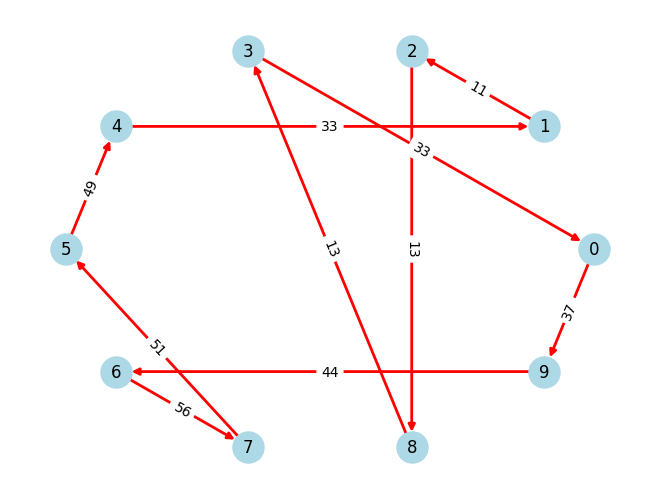

In [50]:
prob.solve()

print("Valeur optimale:", pulp.value(prob.objective))

chemin = [0]

while len(chemin) < n:
    i = chemin[-1]
    for j in villes:
        if i != j and pulp.value(x[i, j]) > 0.5:
            chemin.append(j)
            break
            
chemin.append(0)

print(pulp.LpStatus[prob.status])
print(chemin)


# =========== Traçage du graphe ===========


G = nx.DiGraph()
G.add_nodes_from(villes)

for i in range(len(chemin) - 1):
    G.add_edge(chemin[i], chemin[i+1], weight=C[chemin[i]][chemin[i+1]])

pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='red', width=2)

edges_titre = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_titre)

plt.show()